In [1]:
!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
     |████████████████████████████████| 11.5MB 7.9MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
     |████████████████████████████████| 22.9MB 1.5MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
     |████████████████████████████████| 20.3MB 1.3MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
     |████████████████████████████████| 6.1MB 6.6MB/s 
     |████████████████████████████████| 184kB 4.5MB/s 
     |████████████████████████████████| 235kB 9.5MB/s 
     |████████████████████████████████| 2.2MB 12.8MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.6.1-cp36-none-any.whl size=308552 sha256=4f372c30817517ba99d5670a0f3d239832930877ae5f3d51bf6ade2f7a6f19d9
  Stored in directory: /root/.cache/pip/wheels/e6/25/ea/3d71d2088dccc63214fa59259dcc598ded4150a5f8b41d84ff
Succ

In [4]:
import os.path as osp
import argparse

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv,GATConv  # noqa
from torch_geometric.utils import negative_sampling
from torch_geometric.data import NeighborSampler

dataset =Planetoid(root='/tmp/Cora', name='Cora',transform=T.NormalizeFeatures())
data = dataset[0]

x = data.x
y = data.y.squeeze()


In [3]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

In [5]:
class Net(torch.nn.Module):
    def __init__(self,mode='UNSUP',conv='GCN'):
        super(Net, self).__init__()
        self.mode = mode
        self.conv=conv
        self.num_layers = 2
        
        self.convs = torch.nn.ModuleList()
    
        if self.mode=='UNSUP':
            out_channels = 128
        elif self.mode=='SUP':
            out_channels = dataset.num_classes
        
        if self.conv == 'GCN':
            self.convs.append(GCNConv(dataset.num_features, 260))
            self.convs.append(GCNConv(260, out_channels))
        if self.conv == 'SAGE':
            self.convs.append(SAGEConv(dataset.num_features, 260))
            self.convs.append(SAGEConv(260, out_channels))
        if self.conv == 'GAT':
            self.convs.append(GATConv(dataset.num_features, 260))
            self.convs.append(GATConv(260, out_channels))
                
    def forward(self,x,adjs):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.convs[0](x, edge_index, edge_weight))
        x = F.dropout(x, training=self.training)
        x = self.convs[1](x, edge_index, edge_weight)
        if self.mode=='UNSUP':
            return x
        elif self.mode=='SUP':
            return x.log_softmax(dim=-1)
            
    def loss_RW_SAGE(self,out, pos_rw,neg_rw):
        # Positive loss.
        pos_loss=0
        length = 0 
        start, rest = pos_rw[:, 0], pos_rw[:, 1:].contiguous()
        h_start = out[start].view(pos_rw.size(0), 1,128)
        h_rest = out[rest.view(-1)].view(pos_rw.size(0), -1,128)
        dot = (h_start * h_rest).sum(dim=-1).view(-1)
        pos_loss = -torch.log(torch.sigmoid(dot)).mean()
        
        # Negative loss.
        neg_loss=0
        start, rest = neg_rw[:, 0], neg_rw[:, 1:].contiguous()

        h_start =out[start].view(neg_rw.size(0), 1,128)
        h_rest =  out[rest.view(-1)].view(neg_rw.size(0), -1,128)

        dot = (h_start * h_rest).sum(dim=-1).view(-1)
        neg_loss = -torch.log(torch.sigmoid((-1)*dot)).mean()

        return pos_loss + neg_loss
        
    def loss_SAGE(self,out,pos_edge_index):
        pos_loss = 0 
        for i in range(len(pos_edge_index[0])):
            pos_loss -= torch.log(torch.sigmoid(torch.dot(out[pos_edge_index[0][i]],out[pos_edge_index[1][i]])))
        pos_loss = pos_loss/len(pos_edge_index[0])
        
        ##negative sampling
        neg_edge_index = negative_sampling(torch.Tensor(pos_edge_index), out[data.train_mask].size(0))
        neg_edge_index = neg_edge_index.tolist()
        neg_loss = 0 
        for i in range(len(neg_edge_index[0])):
            neg_loss -= torch.log(torch.sigmoid((-1)*torch.dot(out[neg_edge_index[0][i]],out[neg_edge_index[1][i]])))
        neg_loss = neg_loss/len(neg_edge_index[0])
        
        return pos_loss + neg_loss
    
    ##loss function for supervised     
    def loss_sup(self, pred, label):
        return F.nll_loss(pred, label)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data =data.to(device)

In [6]:
#Сэмплирование позитивных и негативных примеров  
from torch.utils.data import DataLoader
from torch_sparse import SparseTensor
#loader = DataLoader(data.x,batch_size = 10)
row,col = data.edge_index
row = row.to(device)
col = col.to(device)
adj = SparseTensor(row=row, col=col, sparse_sizes=(data.num_nodes, data.num_nodes)).to(device)
try:
    import torch_cluster  # noqa
    random_walk = torch.ops.torch_cluster.random_walk
except ImportError:
    random_walk = None
def pos_sample(batch):
        p=1
        q=1
        walk_length = 20
        walks_per_node = 10
        context_size = 10
        batch = batch.repeat(walks_per_node)
        rowptr, col, _ = adj.csr()
        rowptr = rowptr.to(device)
        col = col.to(device)
        rw = random_walk(rowptr, col, batch,  walk_length, p, q)
        walks = []
        num_walks_per_rw = 1 + walk_length + 1 - context_size
        for j in range(num_walks_per_rw):
            walks.append(rw[:, j:j + context_size])
        return torch.cat(walks, dim=0)
def neg_sample(batch):
    walks_per_node = 10
    num_negative_samples = 1
    walk_length = 20 
    context_size = 10
    batch = batch.repeat(walks_per_node * num_negative_samples)

    rw = torch.randint(adj.sparse_size(0), (batch.size(0), walk_length)).to(device)
    rw = torch.cat([batch.view(-1, 1), rw], dim=-1)

    walks = []
    num_walks_per_rw = 1 + walk_length + 1 - context_size
    for j in range(num_walks_per_rw):
        walks.append(rw[:, j:j + context_size])
    return torch.cat(walks, dim=0)
def sample(batch):
    if not isinstance(batch, torch.Tensor):
        batch = torch.tensor(batch, device=device)
    return pos_sample(batch),neg_sample(batch)
loader = DataLoader(range(adj.sparse_size(0)),collate_fn=sample)


In [ ]:
# positive samples for training set
l = torch.Tensor(list(range(len(x))))
data.train_mask.tolist()
l[data.train_mask.tolist()]
pos_index = [[],[]]
for i,ind in enumerate(data.edge_index[0]):
    if ind in l[data.train_mask.tolist()]:
        if data.edge_index[1][i] in l[data.train_mask.tolist()]:
            pos_index[0].append(ind)
            pos_index[1].append(data.edge_index[1][i])

In [7]:
#UNSUPERVISED
model = Net(mode='UNSUP',conv='SAGE')
model.type(torch.cuda.FloatTensor)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split 

def train():
    model.train()
    total_loss = 0
    out = model.forward(x.to(device),data)
    optimizer.zero_grad()
    for i, (pos_rw, neg_rw) in enumerate(loader):
        loss = model.loss_RW_SAGE(out, pos_rw.to(device), neg_rw.to(device))
        total_loss += loss
    total_loss.backward()
    optimizer.step()            
    return total_loss / len(loader)
import collections
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
@torch.no_grad()
def test():
    model.eval()
    out = model.forward(x.to(device),data.to(device))
    y_true = y.cpu().detach().numpy()
    clf = MLPClassifier(random_state=1, max_iter=2000).fit(out.cpu().detach().numpy(),y_true)
    y_pred = clf.predict(out.cpu().detach().numpy())
    #cm = confusion_matrix(y_true,y_pred)
    results = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:    
        results += [clf.score(out.cpu().detach()[mask].numpy(), y.cpu().detach()[mask].numpy())]
        
    return results

In [8]:
losses=[]
train_accs =[]
val_accs =[]
test_accs=[]
for epoch in range(1, 10):
    loss = train()
    losses.append(loss)
    train_acc, val_acc, test_acc = test()
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    val_accs.append(val_acc)
    
    log = 'Loss: {:.4f}, Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    #print(train_acc)
    print(log.format(loss, epoch, train_acc, val_acc, test_acc))

Loss: 1.3938, Epoch: 001, Train: 0.6500, Val: 0.6660, Test: 0.6670
Loss: 1.3901, Epoch: 002, Train: 0.7071, Val: 0.7140, Test: 0.7160
Loss: 1.3879, Epoch: 003, Train: 0.7571, Val: 0.7240, Test: 0.7380
Loss: 1.3865, Epoch: 004, Train: 0.7786, Val: 0.7420, Test: 0.7590
Loss: 1.3857, Epoch: 005, Train: 0.8214, Val: 0.7920, Test: 0.7940
Loss: 1.3854, Epoch: 006, Train: 0.8643, Val: 0.8280, Test: 0.8190
Loss: 1.3852, Epoch: 007, Train: 0.8643, Val: 0.8300, Test: 0.8420
Loss: 1.3852, Epoch: 008, Train: 0.8643, Val: 0.8300, Test: 0.8350
Loss: 1.3852, Epoch: 009, Train: 0.8357, Val: 0.8180, Test: 0.8300


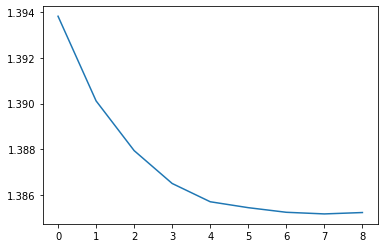

In [9]:
import matplotlib.pyplot as plt
plt.plot(losses)

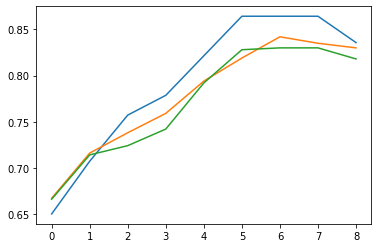

In [10]:
plt.plot(train_accs)
plt.plot(test_accs)
plt.plot(val_accs)